## Курсовой проект для курса "Алгоритмы анализа данных"

**Задание:** предсказать вероятность того, подойдет ли репетитор для подготовки к экзамену по математике (вероятность принадлежности к первому классу). Вам будут даны два датасета: train.csv (содержит признаки и целевую переменную) и test.csv (только признаки).

**Целевая переменная:** choose - целевое значени, выбирать или нет преподавателя

**Метрика качества:** ROC AUC

**Описание датасета:**
<ul>
    <li>Id - айди</li>
    <li>age - возраст преподавателя</li>
    <li>years_of_experience - стаж преподавателя</li>
    <li>qualification - квалификация преподавателя</li>
    <li>physics - преподает ли физику</li>
    <li>chemistry - преподает ли химию</li>
    <li>biology - преподает ли биологию</li>
    <li>english - преподает ли английский</li>
    <li>geography - преподает ли географию</li>
    <li>history - преподает ли историю</li>
    <li>mean_exam_points - средний балл за экзамен учеников</li>
    <li>choose - целевое значени, выбирать или нет преподавателя</li>
    </ul>

## Содержание
* [Подготовка датасет, оптимизация](#prep)
* [Цель и общее описание модели](#general)
* [1. Распределение целевой переменной](#target)
* [2. Анализ признаков и корректировка данных](#features)
    * [2.1 Количественные признаки](#num_features)
    * [2.2 Категориальные/бинарные признаки](#cat_features)
    * [2.3 Матрица корреляций](#corr)
* [3. Анализ зависимости таргета от фичей](#target_features)
    * [3.1 Количественные признаки](#num_features_target)
    * [3.2 Категориальные / бинарные признаки](#cat_bin_features)
* [4. Моделирование](#model)
    * [4.1 Отбор факторов](#model_factor)
    * [4.2 Стандартизация](#model_standart)    
    * [4.3 Разбиение](#model_devide)
    * [4.4 Логистическая регрессия](#model_lr)
    * [4.5 Дерево решений](#model_tree)
* [5. Прогнозирование](#estimate)
    * [5.1 Обработка данных](#est_ev)
    * [5.2 Применение модели и сохранение](#est_save)

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn import over_sampling, under_sampling
import matplotlib.pyplot as plt
import seaborn as sns

# Подготовка dataset, оптимизация<a class='anchor' id='prep'>

In [2]:
#Пути к директориям
DATASET_PATH = 'c_train.csv'
PREPARED_DATASET_PATH = 'c_train_prepared.csv'

In [3]:
test = pd.read_csv('c_test.csv')

In [4]:
#Данные
data_row = pd.read_csv(DATASET_PATH, sep=',')
data_row.head()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points,choose
0,0,35.0,0.0,2150.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,74.0,0
1,1,52.0,2.0,1250.0,2.0,1.0,0.0,1.0,0.0,0.0,1.0,57.0,1
2,2,29.0,3.0,1750.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,66.0,0
3,3,33.0,3.0,1050.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,66.0,1
4,4,46.0,3.0,2250.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,73.0,0


In [5]:
#оптимизация памяти
def reduce_mem_usage(data_row):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = data_row.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is: {:.2f} MB'.format(start_mem))
    
    for col in data_row.columns:
        col_type = data_row[col].dtype
        
        if col_type != object:
            c_min = data_row[col].min()
            c_max = data_row[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    data_row[col] = data_row[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    data_row[col] = data_row[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    data_row[col] = data_row[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    data_row[col] = data_row[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    data_row[col] = data_row[col].astype(np.float32)
                else:
                    data_row[col] = data_row[col].astype(np.float64)
        else:
            data_row[col] = data_row[col].astype('category')

    end_mem = data_row.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return data_row

In [6]:
data_row.dtypes

Id                       int64
age                    float64
years_of_experience    float64
lesson_price           float64
qualification          float64
physics                float64
chemistry              float64
biology                float64
english                float64
geography              float64
history                float64
mean_exam_points       float64
choose                   int64
dtype: object

In [7]:
data_row = reduce_mem_usage(data_row)

Memory usage of dataframe is: 0.99 MB
Memory usage after optimization is: 0.45 MB
Decreased by 54.8%


In [8]:
#функция стандартизации
def standard_scale(x):
    res = (x - x.mean(axis=0)) / x.std(axis=0)
    return res

In [9]:
#запись результатов моделей
results_all = {}

# 1. Распределение целевой переменной<a class='anchor' id='target'>

In [10]:
data_row['choose'].describe()

count    10000.000000
mean         0.110900
std          0.314024
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: choose, dtype: float64

(array([8891.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1109.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

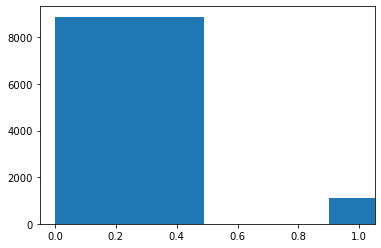

In [11]:
#график целевой переменной

plt.hist(data_row['choose'], width=0.49)

**Значений с показателем - брать (1) существенно меньше около 11%, в основном показатель - не выбирать (почти 89%)**

Данный дисбаланс при разбиении для тестирования необходимо учесть и скорректировать.

# 2. Анализ признаков и корректировка данных<a class='anchor' id='features'>

### 2.1 Количественные признаки<a class='anchor' id='num_features'>

In [12]:
data_num_features = data_row[['age', 'years_of_experience', 'lesson_price', 'qualification', 'mean_exam_points']]
data_num_features

,age,years_of_experience,lesson_price,qualification,mean_exam_points
0,35.0,0.0,2150.0,2.0,74.0
1,52.0,2.0,1250.0,2.0,57.0
2,29.0,3.0,1750.0,1.0,66.0
3,33.0,3.0,1050.0,1.0,66.0
4,46.0,3.0,2250.0,2.0,73.0
...,...,...,...,...,...
9995,55.0,2.0,2150.0,2.0,79.0
9996,53.0,2.0,1350.0,1.0,59.0
9997,44.0,5.0,1750.0,1.0,59.0
9998,41.0,0.0,1700.0,2.0,72.0


In [13]:
mean_data_f = np.mean(data_num_features).round(1)
min_data_f = np.min(data_num_features, axis = 0).round(1)
max_data_f = np.max(data_num_features, axis = 0).round(1)
null_data_f = data_num_features.isnull().astype(np.int).sum()

In [14]:
keys_data_f = mean_data_f.keys()
np.column_stack([keys_data_f, mean_data_f, min_data_f, max_data_f, null_data_f])

array([['age', 45.79999923706055, 23.0, 68.0, 0],
       ['years_of_experience', 2.0, 0.0, 9.0, 0],
       ['lesson_price', 1702.4000244140625, 200.0, 3950.0, 0],
       ['qualification', 1.7000000476837158, 1.0, 4.0, 0],
       ['mean_exam_points', 64.4000015258789, 33.0, 100.0, 0]],
      dtype=object)

(array([4891.,    0.,    0., 3033.,    0.,    0., 2018.,    0.,    0.,
          58.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

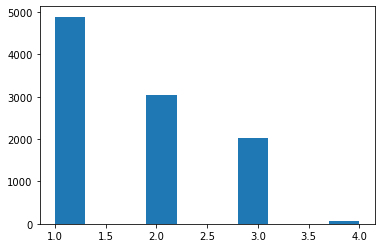

In [15]:
plt.hist(data_row['qualification'])

(array([  19.,  148., 2453., 3257., 1348., 1811.,  609.,  268.,   78.,
           9.]),
 array([ 200.,  575.,  950., 1325., 1700., 2075., 2450., 2825., 3200.,
        3575., 3950.], dtype=float32),
 <BarContainer object of 10 artists>)

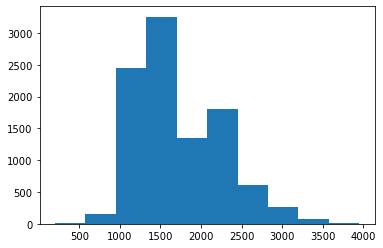

In [16]:
plt.hist(data_row['lesson_price'])

(array([2774., 1842., 1743., 1545., 1177.,  581.,  234.,   73.,   22.,
           9.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

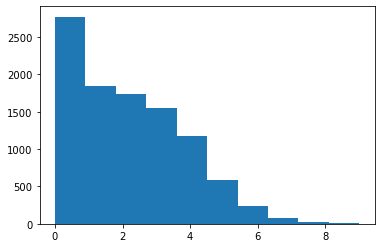

In [17]:
plt.hist(data_row['years_of_experience'])

(array([ 103.,  253.,  880., 1356., 2310., 1861., 1840.,  802.,  442.,
         153.]),
 array([23. , 27.5, 32. , 36.5, 41. , 45.5, 50. , 54.5, 59. , 63.5, 68. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

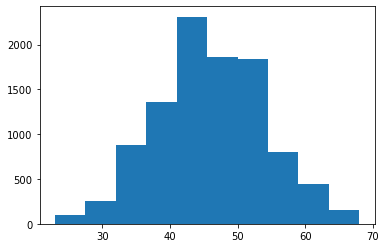

In [18]:
plt.hist(data_row['age'])

(array([ 287.,  629., 1208., 1698., 2105., 1553.,  764., 1044.,  632.,
          80.]),
 array([ 33. ,  39.7,  46.4,  53.1,  59.8,  66.5,  73.2,  79.9,  86.6,
         93.3, 100. ], dtype=float32),
 <BarContainer object of 10 artists>)

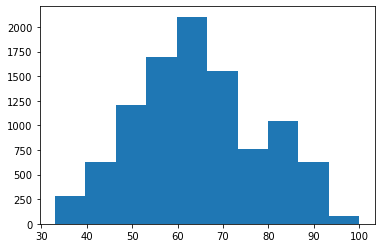

In [19]:
plt.hist(data_row['mean_exam_points'])

Пропущенных значений нет, выбросов для корректировок - тоже.

По квалификации количество преподавателей уровня 4 - минимальное (40 из 10 000)

### 2.2 Категориальные / бинарные признаки<a class='anchor' id='cat_features'>

In [20]:
data_categ_features = data_row[['physics', 'chemistry', 'biology', 'english', 'geography', 'history']]
data_categ_features

,physics,chemistry,biology,english,geography,history
0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,1.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
9995,1.0,0.0,0.0,0.0,0.0,0.0
9996,0.0,0.0,0.0,0.0,0.0,0.0
9997,0.0,0.0,0.0,0.0,0.0,1.0
9998,1.0,0.0,0.0,0.0,0.0,0.0


In [21]:
mean_data_c = np.mean(data_categ_features).round(1)
min_data_c = np.min(data_categ_features, axis = 0).round(1)
max_data_c = np.max(data_categ_features, axis = 0).round(1)
null_data_c = data_categ_features.isnull().astype(np.int).sum()

In [22]:
keys_data_c = mean_data_c.keys()
np.column_stack([keys_data_c, mean_data_c, min_data_c, max_data_c, null_data_c])

array([['physics', 0.4000000059604645, 0.0, 1.0, 0],
       ['chemistry', 0.10000000149011612, 0.0, 1.0, 0],
       ['biology', 0.10000000149011612, 0.0, 1.0, 0],
       ['english', 0.10000000149011612, 0.0, 1.0, 0],
       ['geography', 0.0, 0.0, 1.0, 0],
       ['history', 0.0, 0.0, 1.0, 0]], dtype=object)

In [23]:
data_c = {}
data_c_p = [len(data_categ_features[data_categ_features['physics'] == 0]), 
            len(data_categ_features[data_categ_features['physics'] == 1])]
data_c.update({'physics': data_c_p})
data_c_c = [len(data_categ_features[data_categ_features['chemistry'] == 0]), 
            len(data_categ_features[data_categ_features['chemistry'] == 1])]
data_c.update({'chemistry': data_c_c})
data_c_b = [len(data_categ_features[data_categ_features['biology'] == 0]), 
            len(data_categ_features[data_categ_features['biology'] == 1])]
data_c.update({'biology': data_c_b})
data_c_e = [len(data_categ_features[data_categ_features['english'] == 0]), 
            len(data_categ_features[data_categ_features['english'] == 1])]
data_c.update({'english': data_c_e})
data_c_g = [len(data_categ_features[data_categ_features['geography'] == 0]), 
            len(data_categ_features[data_categ_features['geography'] == 1])]
data_c.update({'geography': data_c_g})
data_c_h = [len(data_categ_features[data_categ_features['history'] == 0]), 
            len(data_categ_features[data_categ_features['history'] == 1])]
data_c.update({'history': data_c_h})

data_c

{'physics': [6294, 3706],
 'chemistry': [8785, 1215],
 'biology': [8828, 1172],
 'english': [9409, 591],
 'geography': [9723, 277],
 'history': [9820, 180]}

Видно, что совсем мало учителей истории, географии, английского

### 2.3 Матрица корреляций<a class='anchor' id='corr'>

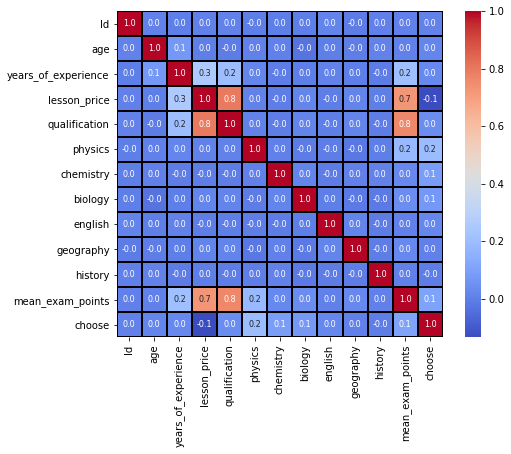

In [24]:
plt.figure(figsize=(8, 6))
sns.heatmap(data_row.corr(), cmap= 'coolwarm', linewidths=1, fmt='.1f', annot=True, linecolor='black', square=True, annot_kws={'size':8})
plt.show()

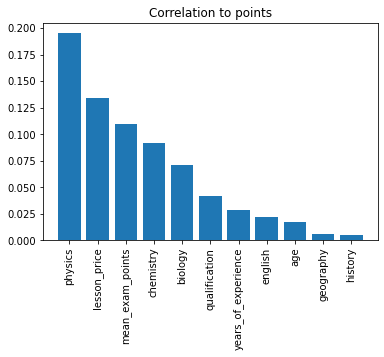

In [25]:
corrmat = data_row.loc[:, data_row.columns != 'Id'].corrwith(
    data_row['choose']).abs().sort_values(ascending=False)[1:]
plt.bar(corrmat.index, corrmat.values)
plt.title('Correlation to points')
plt.xticks(rotation='vertical')
plt.show()

корреляция с учителями по физике и ценой.

# 3. Анализ зависимости таргета от признаков<a class='anchor' id='target_features'>

## 3.1 Количественные признаки<a class='anchor' id='num_features_target'>

C:\Users\artemiyb1\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


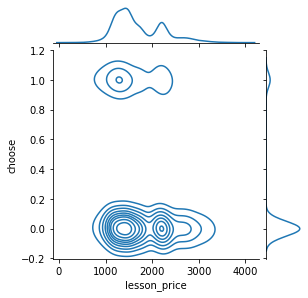

In [26]:
#покажем связь на графике
grid = sns.jointplot(data_row['lesson_price'], data_row['choose'], kind='kde')
grid.fig.set_figwidth(4)
grid.fig.set_figheight(4)

plt.show()

## 3.2 Категориальные / бинарные признаки<a class='anchor' id='cat_bin_features'>

C:\Users\artemiyb1\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


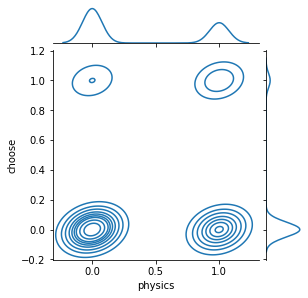

In [27]:
#покажем связь на графике
grid = sns.jointplot(data_row['physics'], data_row['choose'], kind='kde')
grid.fig.set_figwidth(4)
grid.fig.set_figheight(4)

plt.show()

# 4. Моделирование<a class='anchor' id='model'>

## 4.1 Отбор факторов<a class='anchor' id='model_factor'>

Помимо корреляционого анализа, проведем анализ снижение размерности по Методу главных компонент

In [28]:
data_num_features_std = standard_scale(data_num_features)

In [29]:
# Найдем собственные векторы и собственные значения
 
covariance_matrix = data_num_features_std.T @ data_num_features_std

eig_values, eig_vectors = np.linalg.eig(covariance_matrix)

# сформируем список кортежей (собственное значение, собственный вектор)
eig_pairs = [(np.abs(eig_values[i]), eig_vectors[:, i]) for i in range(len(eig_values))]

# и отсортируем список по убыванию собственных значений
eig_pairs.sort(key=lambda x: x[0], reverse=True)

print('Собственные значения и собственные векторы в порядке убывания:')
for i in eig_pairs:
    print(i)

Собственные значения и собственные векторы в порядке убывания:
(26175.771, array([0.00926909, 0.23039687, 0.56498307, 0.56783915, 0.5524348 ],
      dtype=float32))
(10395.343, array([ 0.87329423,  0.47131035, -0.0487339 , -0.09016294, -0.06869803],
      dtype=float32))
(8722.173, array([-0.48698646,  0.8493918 , -0.07128652, -0.13888526, -0.13041021],
      dtype=float32))
(2749.205, array([ 0.00958147, -0.03295182,  0.5712359 ,  0.21481416, -0.7914334 ],
      dtype=float32))
(1952.5734, array([ 0.00486631,  0.04723912, -0.5890899 ,  0.77717125, -0.21615452],
      dtype=float32))


In [30]:
eig_sum = sum(eig_values)
var_exp = [(i / eig_sum) * 100 for i in sorted(eig_values, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print(f'Доля дисперсии, описываемая каждой из компонент \n{var_exp}')

# а теперь оценим кумулятивную (то есть накапливаемую) дисперсию при учитывании каждой из компонент
print(f'Кумулятивная доля дисперсии по компонентам \n{cum_var_exp}')

Доля дисперсии, описываемая каждой из компонент 
[52.35670999826235, 20.792737560621124, 17.446067437460997, 5.498952842213722, 3.9055321614418013]
Кумулятивная доля дисперсии по компонентам 
[ 52.35671     73.14944756  90.595515    96.09446784 100.        ]


Таким образом, первая главная компонента (возраст) описывает 52% информации, а первые 4 ('age', 'years_of_experience', 'lesson_price', 'qualification',) в сумме - 96%. В то же время последняя компонента ( 'mean_exam_points') описывает всего 3.9%. 

**Исходя из этого вводим новую переменную - показатель зависимости от цены и возраста**

Возраст до 30 = 1В
от 30 до 50 = 2В
больше 50 = 3D

Цена до 1000 = 1М
от 1000 до 2100 = 2М
больше 2100 = 3М


In [31]:
#показатель зависимости от цены и возраста
def age_price(X):

    X['age_price'] = 2
    X.loc[((X['age'] < 30) | ((X['age'] >= 30) & (X['age'] < 50)) | (X['age'] >= 50)) & 
          (X['lesson_price'] <= 1000), 'age_price'] = 1
    X.loc[(((X['age'] >= 30) & (X['age'] < 50)) | (X['age'] >= 50)) & 
          (X['lesson_price'] > 2100), 'age_price'] = 5
    X.loc[((X['age'] >= 30) & (X['age'] < 50)) & 
          ((X['lesson_price'] > 1000) & (X['lesson_price'] <= 2100)), 'age_price'] = 4
    X.loc[(X['age'] >= 50) & 
          ((X['lesson_price'] > 1000) & (X['lesson_price'] <= 2100)), 'age_price'] = 3
    X.loc[(X['age'] < 30) & 
          (X['lesson_price'] > 2100), 'age_price'] = 3
    X.loc[(X['age'] < 30) & 
          ((X['lesson_price'] > 1000) & (X['lesson_price'] <= 2100)), 'age_price'] = 2

    return X


(array([ 311.,    0.,  133.,    0.,    0., 2333.,    0., 4665.,    0.,
        2558.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

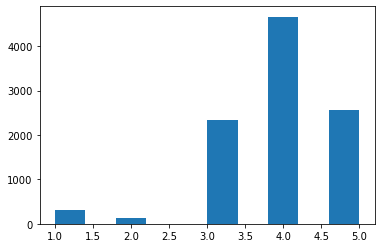

In [32]:
data_row = age_price(data_row)
plt.hist(data_row['age_price'])

C:\Users\artemiyb1\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


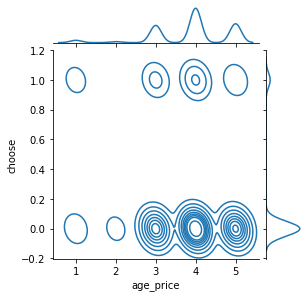

In [33]:
grid = sns.jointplot(data_row['age_price'], data_row['choose'], kind='kde')
grid.fig.set_figwidth(4)
grid.fig.set_figheight(4)

plt.show()

In [34]:
# Найдем собственные векторы и собственные значения
 
covariance_matrix = data_categ_features.T @ data_categ_features

eig_values, eig_vectors = np.linalg.eig(covariance_matrix)

# сформируем список кортежей (собственное значение, собственный вектор)
eig_pairs = [(np.abs(eig_values[i]), eig_vectors[:, i]) for i in range(len(eig_values))]

# и отсортируем список по убыванию собственных значений
eig_pairs.sort(key=lambda x: x[0], reverse=True)

print('Собственные значения и собственные векторы в порядке убывания:')
for i in eig_pairs:
    print(i)

Собственные значения и собственные векторы в порядке убывания:
(3881.0828, array([0.9672478 , 0.17799369, 0.16347297, 0.06984656, 0.02760454,
       0.01964782], dtype=float32))
(1199.7118, array([ 0.24683239, -0.7440662 , -0.61678946, -0.06507186, -0.02461063,
       -0.01303858], dtype=float32))
(1036.0455, array([ 0.01279946,  0.64141494, -0.7667795 , -0.02048835,  0.00410122,
        0.0059791 ], dtype=float32))
(572.7543, array([-0.05257048, -0.04929543, -0.0683834 ,  0.99398303,  0.04577475,
        0.00569548], dtype=float32))
(273.0774, array([ 0.01857281,  0.02392981,  0.0135484 ,  0.04915913, -0.9981067 ,
       -0.01628565], dtype=float32))
(178.32837, array([-0.0152674 , -0.01637065, -0.00606188, -0.006962  , -0.01741105,
        0.9995552 ], dtype=float32))


In [35]:
eig_sum = sum(eig_values)
var_exp = [(i / eig_sum) * 100 for i in sorted(eig_values, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print(f'Доля дисперсии, описываемая каждой из компонент \n{var_exp}')

# а теперь оценим кумулятивную (то есть накапливаемую) дисперсию при учитывании каждой из компонент
print(f'Кумулятивная доля дисперсии по компонентам \n{cum_var_exp}')

Доля дисперсии, описываемая каждой из компонент 
[54.34928857761558, 16.800332887326267, 14.508409389666738, 8.020645045093278, 3.8240776909405043, 2.497246409357632]
Кумулятивная доля дисперсии по компонентам 
[ 54.34928858  71.14962146  85.65803085  93.6786759   97.50275359
 100.        ]


Категориальные признаки по главным компонентам соответствуют выводам дисперсионного анализа physics, chemistry, biology - в наибольшей степени описывают целевое значение

In [36]:
data_row.insert(0, 'free', 1)

**После анализа принято решение рассматривать в модели следующие параметры:**
 - age_price (новая переменная)                    
 - years_of_experience    
 - qualification
 - mean_exam_points
 - physics                
 - chemistry              
 - biology                

In [37]:
data_all = ['free', 'years_of_experience', 'qualification', 'physics', 'chemistry', 'biology', 'age_price', 'mean_exam_points', 'choose']

feature_names = ['free', 'years_of_experience', 'qualification', 'physics', 'chemistry', 'biology', 'age_price', 'mean_exam_points']

target_name = 'choose'

In [38]:
data_row = data_row[data_all]

In [39]:
data_row.head()

,free,years_of_experience,qualification,physics,chemistry,biology,age_price,mean_exam_points,choose
0,1,0.0,2.0,0.0,0.0,0.0,5,74.0,0
1,1,2.0,2.0,1.0,0.0,1.0,3,57.0,1
2,1,3.0,1.0,1.0,0.0,0.0,2,66.0,0
3,1,3.0,1.0,0.0,0.0,0.0,4,66.0,1
4,1,3.0,2.0,1.0,0.0,0.0,5,73.0,0


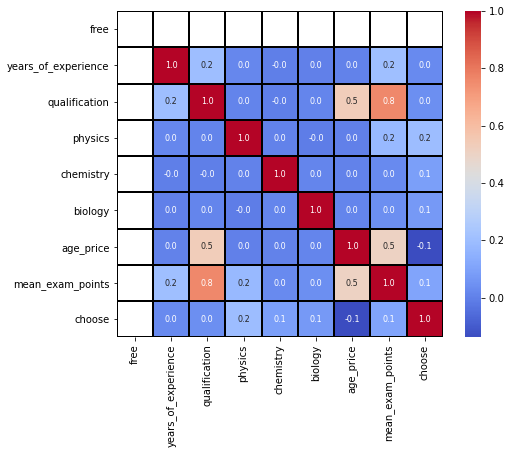

In [40]:
plt.figure(figsize=(8, 6))
sns.heatmap(data_row.corr(), cmap= 'coolwarm', linewidths=1, fmt='.1f', annot=True, linecolor='black', square=True, annot_kws={'size':8})
plt.show()

In [41]:
# Итоговая функция подготовки данных
class DataPreprocessing:
    def transform(self, X):
        X['age_price'] = 2
        X.loc[((X['age'] < 30) | ((X['age'] >= 30) & (X['age'] < 50)) | (X['age'] >= 50)) & 
              (X['lesson_price'] <= 1000), 'age_price'] = 1
        X.loc[(((X['age'] >= 30) & (X['age'] < 50)) | (X['age'] >= 50)) & 
              (X['lesson_price'] > 2100), 'age_price'] = 5
        X.loc[((X['age'] >= 30) & (X['age'] < 50)) & 
              ((X['lesson_price'] > 1000) & (X['lesson_price'] <= 2100)), 'age_price'] = 4
        X.loc[(X['age'] >= 50) & 
              ((X['lesson_price'] > 1000) & (X['lesson_price'] <= 2100)), 'age_price'] = 3
        X.loc[(X['age'] < 30) & 
              (X['lesson_price'] > 2100), 'age_price'] = 3
        X.loc[(X['age'] < 30) & 
              ((X['lesson_price'] > 1000) & (X['lesson_price'] <= 2100)), 'age_price'] = 2
        
        X.insert(0, 'free', 1)
        
        all_data = ['Id', 'free', 'years_of_experience', 'qualification', 'physics', 'chemistry', 'biology', 'mean_exam_points', 'age_price']
        feature_names = ['free', 'years_of_experience', 'qualification', 'physics', 'chemistry', 'biology', 'mean_exam_points', 'age_price']
        X = X[all_data]
        return X


## 4.2 Стандартизация<a class='anchor' id='model_standart'>

Поскольку в итоговом спискевсе имеют примерно одну размерность, стандартизацию можно не проводить

In [42]:
#сохранение датасета
data_row.to_csv(PREPARED_DATASET_PATH, index=False, encoding='utf-8', sep=',')

## 4.3 Разбиение<a class='anchor' id='model_devide'>

Поскольку имеется значимый дисбаланс классов целевой переменной, необходимо случайным образом выбрать наблюдения из класса меньшинства и добавить их в набор данных, пока мы не достигнем баланса между большинством и классом меньшинства. 

In [43]:
num_0 = len(data_row[data_row['choose']==0])
num_1 = len(data_row[data_row['choose']==1])

oversampled_data = pd.concat([data_row[data_row['choose']==0] , data_row[data_row['choose']==1].sample(num_0, replace=True) ])

In [44]:
undersampled_data = pd.concat([data_row[data_row['choose']==0].sample(num_1) , data_row[data_row['choose']==1] ])

(array([8891.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        8891.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

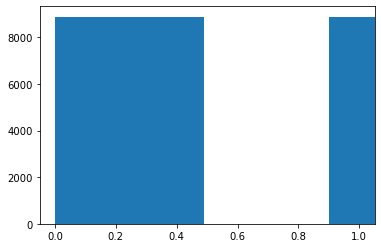

In [45]:
plt.hist(oversampled_data['choose'], width=0.49)

In [46]:
X = oversampled_data[feature_names]
y = oversampled_data[target_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=True, random_state=42)

## 4.4 Логистическая регрессия<a class='anchor' id='model_lr'>

In [47]:
def calc_logloss(y, y_pred):
    eps = 1e-8
    y_pred = np.clip(y_pred, eps, 1 - eps)
    err = - np.mean(y * np.log(y_pred) + (1.0 - y) * np.log(1.0 - y_pred))
    return err

In [48]:
def sigmoid(z):
    res = 1 / (1 + np.exp(-z))
    return res

In [49]:
def eval_model(X, y, iterations, eta=1e-4):
    np.random.seed(42)
    W = np.random.randn(X.shape[1])
    n = X.shape[0]
    
    for i in range(iterations):
        z = np.dot(X, W)
        y_pred = sigmoid(z)
        err = calc_logloss(y, y_pred)
        
        dQ = 1/n * X.T @ (y_pred - y)
        W -= eta * dQ
        if i % (iterations / 10) == 0:
            print(i, W, err)
            
    final_error = calc_logloss(y, y_pred)
    return W, final_error

In [50]:
def calc_pred_proba(W, X):
    y_pred_proba = np.around(sigmoid(np.dot(X, W)), decimals = 3)
    return y_pred_proba

In [51]:
W, error = eval_model(X_train, y_train, iterations=5000, eta=0.001)

0 free                   0.496212
years_of_experience   -0.139248
qualification          0.646825
physics                1.522862
chemistry             -0.234206
biology               -0.234193
age_price              1.577236
mean_exam_points       0.735363
dtype: float64 9.242281755424944
500 free                   0.471196
years_of_experience   -0.082434
qualification          0.603774
physics                1.530377
chemistry             -0.222278
biology               -0.225140
age_price              1.350820
mean_exam_points      -0.106933
dtype: float64 1.0533851816798654
1000 free                   0.459422
years_of_experience   -0.016241
qualification          0.582904
physics                1.540783
chemistry             -0.208206
biology               -0.213933
age_price              1.175972
mean_exam_points      -0.098178
dtype: float64 0.9812121190060656
1500 free                   0.448266
years_of_experience    0.031492
qualification          0.562692
physics            

In [52]:
p1 = calc_pred_proba(W, X_test)
p1 

array([0.538, 0.369, 0.676, ..., 0.456, 0.673, 0.333])

(array([ 113.,  825., 1254.,  926.,  463.,  670., 1259., 1082.,  465.,
          56.]),
 array([0.153 , 0.2281, 0.3032, 0.3783, 0.4534, 0.5285, 0.6036, 0.6787,
        0.7538, 0.8289, 0.904 ]),
 <BarContainer object of 10 artists>)

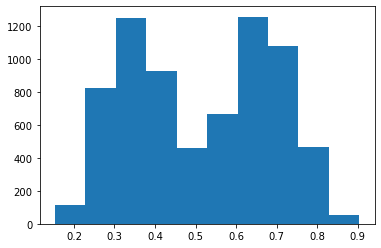

In [53]:
plt.hist(p1)

In [54]:
def calc_pred(W, X):
    y_pred_proba = calc_pred_proba(W, X)
    y_pred = np.where(y_pred_proba > 0.5, 1, 0)
    return y_pred

In [55]:
pred = calc_pred(W, X_test)
pred

array([1, 0, 1, ..., 0, 1, 0])

In [56]:
def accuracy(y, y_pred):
    accuracy = np.mean(y == y_pred)
    return accuracy

In [57]:
accuracy(y_test, pred)

0.6225221425558836

In [58]:
results_all['logistic'] = [accuracy(y_test, pred)]

## 4.5 Дерево решений<a class='anchor' id='model_tree'>

In [59]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [60]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [61]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [62]:
# Расчет прироста

def gain(left_labels, right_labels, root_gini):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [63]:
# Разбиение датасета в узле

def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [64]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_samples_leaf = 5

    root_gini = gini(labels)
    
    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
#             if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
#                 continue
            
            current_gain = gain(true_labels, false_labels, root_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [65]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    gain, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)

#     print(time.time(), true_branch)
    false_branch = build_tree(false_data, false_labels)
    
#     print(time.time(), false_branch)
    
    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [66]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [67]:
def predict(data, tree):
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [68]:
# Построим дерево по обучающей выборке
my_tree = build_tree(np.array(X_train), np.array(y_train))

In [69]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index), '<=', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на отрицательном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 3 <= 0.0
--> True:
  Индекс 6 <= 1.0
  --> True:
    Индекс 7 <= 52.0
    --> True:
      Индекс 1 <= 6.0
      --> True:
        Индекс 5 <= 0.0
        --> True:
          Индекс 1 <= 5.0
          --> True:
            Индекс 7 <= 47.0
            --> True:
              Прогноз: 0
            --> False:
              Индекс 7 <= 48.0
              --> True:
                Индекс 1 <= 3.0
                --> True:
                  Индекс 1 <= 2.0
                  --> True:
                    Прогноз: 1
                  --> False:
                    Прогноз: 1
                --> False:
                  Прогноз: 0
              --> False:
                Индекс 7 <= 49.0
                --> True:
                  Прогноз: 0
                --> False:
                  Индекс 1 <= 4.0
                  --> True:
                    Индекс 4 <= 0.0
                    --> True:
                      Индекс 7 <= 51.0
                      --> True:
                       

                                    Индекс 7 <= 68.0
                                    --> True:
                                      Индекс 7 <= 65.0
                                      --> True:
                                        Прогноз: 1
                                      --> False:
                                        Прогноз: 0
                                    --> False:
                                      Прогноз: 1
                                  --> False:
                                    Индекс 7 <= 67.0
                                    --> True:
                                      Индекс 7 <= 65.0
                                      --> True:
                                        Прогноз: 0
                                      --> False:
                                        Прогноз: 1
                                    --> False:
                                      Прогноз: 0
                                --> False:
              

                                        Прогноз: 0
                                  --> False:
                                    Прогноз: 1
                              --> False:
                                Индекс 7 <= 54.0
                                --> True:
                                  Прогноз: 0
                                --> False:
                                  Индекс 1 <= 2.0
                                  --> True:
                                    Индекс 2 <= 1.0
                                    --> True:
                                      Индекс 7 <= 55.0
                                      --> True:
                                        Прогноз: 0
                                      --> False:
                                        Индекс 7 <= 56.0
                                        --> True:
                                          Прогноз: 1
                                        --> False:
                               

                              --> True:
                                Прогноз: 1
                              --> False:
                                Прогноз: 1
                            --> False:
                              Прогноз: 1
                          --> False:
                            Индекс 7 <= 88.0
                            --> True:
                              Прогноз: 1
                            --> False:
                              Индекс 7 <= 89.0
                              --> True:
                                Прогноз: 0
                              --> False:
                                Прогноз: 1
                        --> False:
                          Прогноз: 1
                      --> False:
                        Индекс 7 <= 88.0
                        --> True:
                          Прогноз: 1
                        --> False:
                          Прогноз: 1
                  --> False:
                    И

In [70]:
# Получим ответы для обучающей выборки 
train_answers = predict(np.array(X_train), my_tree)

In [71]:
# И получим ответы для тестовой выборки
answers = predict(np.array(X_test), my_tree)

In [72]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [73]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(np.array(y_train), train_answers)
train_accuracy

90.24275939638204

In [74]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(np.array(y_test), answers)
test_accuracy

85.37888373400816

In [75]:
results_all['tree'] = [test_accuracy]

## 4.6 Выбор лучшей модели<a class='anchor' id='choose'>

In [76]:
df = pd.DataFrame(results_all).T
df.columns=['criteria']

df

,criteria
logistic,0.622522
tree,85.378884


**В целом логистическая модель нормальная, несмотря на невысокую точность предстказаний, ее можно использовать**

Модель случайного леса более точная, однако как добавить веса для расчета определения вероятности предсказания не ясно, поэтому выбираем логистическую модель.

# 5. Прогнозирование<a class='anchor' id='estimate'>

## 5.1 Обработка данных<a class='anchor' id='est_ev'>

In [77]:
test = pd.read_csv('c_test.csv', sep=',')

test = reduce_mem_usage(test)

test = DataPreprocessing().transform(test)

test.head()

Memory usage of dataframe is: 0.92 MB
Memory usage after optimization is: 0.44 MB
Decreased by 52.1%


,Id,free,years_of_experience,qualification,physics,chemistry,biology,mean_exam_points,age_price
0,10000,1,2.0,3.0,0.0,0.0,0.0,90.0,5
1,10001,1,6.0,2.0,1.0,1.0,0.0,71.0,4
2,10002,1,2.0,1.0,0.0,0.0,0.0,45.0,4
3,10003,1,4.0,3.0,1.0,0.0,0.0,92.0,5
4,10004,1,3.0,2.0,1.0,0.0,0.0,58.0,4


## 5.2 Применение модели и сохранение<a class='anchor' id='est_save'>

In [78]:
np.array(test[feature_names])

array([[ 1.,  2.,  3., ...,  0.,  5., 90.],
       [ 1.,  6.,  2., ...,  0.,  4., 71.],
       [ 1.,  2.,  1., ...,  0.,  4., 45.],
       ...,
       [ 1.,  2.,  1., ...,  0.,  4., 63.],
       [ 1.,  5.,  2., ...,  1.,  1., 64.],
       [ 1.,  0.,  1., ...,  1.,  4., 41.]])

In [79]:
test['choose'] = calc_pred_proba(W, test[feature_names])

(array([  35.,  722., 2098., 2120.,  983.,  717., 1159., 1442.,  673.,
          51.]),
 array([0.118 , 0.1974, 0.2768, 0.3562, 0.4356, 0.515 , 0.5944, 0.6738,
        0.7532, 0.8326, 0.912 ]),
 <BarContainer object of 10 artists>)

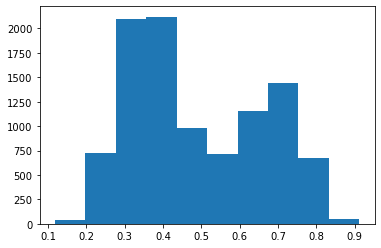

In [80]:
plt.hist(test['choose'])

In [81]:
test[['Id', 'choose']].to_csv('Aberezikov_classification.csv', index=None)